# Project 3: Percolation - FYS4460
Author: Øyvind Sigmundson Schøyen

In this project we'll explore _percolation_ from the project shown here: https://www.uio.no/studier/emner/matnat/fys/FYS4460/v19/notes/project2017-ob3.pdf

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label

We specify the probability `p` of setting a lattice and the lattice sides `L_x` and `L_y`.

In [31]:
p = 0.5 # Probability of setting a lattice point
L_x = L_y = 20 # Size of lattice sides

assert 0 <= p <= 1

In [32]:
site = np.random.choice([0, 1], size=(L_x, L_y), p=[1 - p, p])

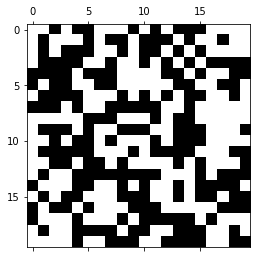

In [33]:
plt.matshow(site, cmap="gray")
plt.show()

In [34]:
label, num_features = label(site)

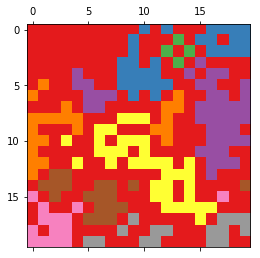

In [37]:
plt.matshow(label, cmap="Set1")
plt.show()